In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [10]:
data = pd.read_csv('/home/ananth/Downloads/digit/train.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


In [11]:
train_data = data.head(37800)
val_data = data.tail(4200)
train_labels = train_data.pop('label')
val_labels = val_data.pop('label')

In [12]:
tf_train_data = tf.data.Dataset.from_tensor_slices((train_data.values, train_labels.values))
print(tf_train_data)

<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [13]:
tf_val_data = tf.data.Dataset.from_tensor_slices((val_data.values, val_labels.values))
print(tf_val_data)

<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


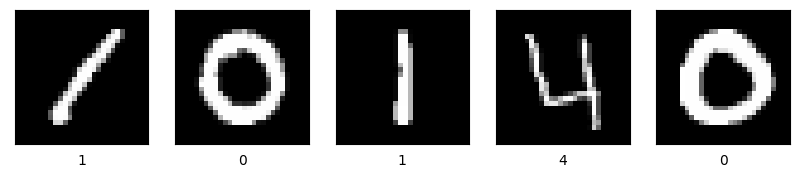

In [14]:
plt.figure(figsize=(10,10))
i = 0

for image, label in tf_train_data.take(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image.numpy().reshape((28, 28)), cmap='gray')
    plt.xlabel(label.numpy())

    i = i + 1

In [15]:
def preprocess_image(image, label):
    image = tf.reshape(image, [28, 28, 1])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [16]:
tf_train_data = tf_train_data.map(
    preprocess_image, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
print(tf_train_data)

<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [17]:
tf_val_data = tf_val_data.map(
    preprocess_image, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
print(tf_val_data)

<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [18]:
def pipeline(tf_data):
    tf_data = tf_data.shuffle(100)
    tf_data = tf_data.batch(32)
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    return tf_data

In [19]:
tf_train_data = pipeline(tf_train_data)
print(tf_train_data)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [20]:
tf_val_data = pipeline(tf_val_data)
print(tf_val_data)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [21]:
#Training - LeNet-5 CNN 

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [23]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

In [24]:
model.compile(
    optimizer=optimiser, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [26]:
#Learningratedecay on no loss and Early Stopping

In [27]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [ ]:
train_log = model.fit(
    tf_train_data,
    validation_data=tf_val_data,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
1182/1182 [==============================] - 27s 21ms/step - loss: 0.2392 - accuracy: 0.9272 - val_loss: 0.0828 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 2/30
1182/1182 [==============================] - 28s 24ms/step - loss: 0.0736 - accuracy: 0.9779 - val_loss: 0.0672 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 3/30
1182/1182 [==============================] - 28s 23ms/step - loss: 0.0520 - accuracy: 0.9839 - val_loss: 0.0709 - val_accuracy: 0.9764 - lr: 0.0010
Epoch 4/30
 439/1182 [==========>...................] - ETA: 13s - loss: 0.0415 - accuracy: 0.9863

In [ ]:
# Model has been trained

In [ ]:
plt.plot(train_log.history['accuracy'], label='accuracy')
plt.plot(train_log.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print('Training accuracy: %f' % train_log.history['accuracy'][-1])
print('Validation accuracy: %f' % train_log.history['val_accuracy'][-1])

In [ ]:
#Testing

In [ ]:
test_data = pd.read_csv('/home/ananth/Downloads/digit/train.csv')
tf_test_data = tf.data.Dataset.from_tensor_slices(([test_data.to_numpy().reshape(len(test_data), 28, 28, 1)]))

In [ ]:
predictions = model.predict(tf_test_data)
predictions = np.argmax(predictions, axis=1)

In [ ]:
plt.figure(figsize=(10,10))

for i, row in test_data.head(15).iterrows():
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(row.values.reshape((28, 28)), cmap='gray')
    plt.xlabel(predictions[i])

In [ ]:
predictions_df = pd.DataFrame(data={'Label': predictions}, index=pd.RangeIndex(start=1, stop=28001))
predictions_df.index = predictions_df.index.rename('ImageId')

predictions_df.to_csv('home/ananth/Downloads/digit/submit.csv')